This notebook is a vewrsion of the original notebook. Instead of preparing the data by padding and masking smaller batches of time series of the trajectories are prepared and fed to the network

Notebook for the GoogleDecimeterChallenge https://www.kaggle.com/competitions/smartphone-decimeter-2023


Also try to run it on google collab, works great only RAM is limited:
https://colab.research.google.com/github/Torbynator/GoogleDecimeterChallenge/blob/main/main.ipynb#scrollTo=TOn-Can4C0YP

#Only for google collab
from google.colab import drive
drive.mount('/content/drive')
!pip install  kaggle
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!kaggle competitions download -c smartphone-decimeter-2023
!unzip /content/smartphone-decimeter-2023.zip

In [44]:
#reading data
import numpy as np 
import pandas as pd
from tqdm import tqdm, trange
import math
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import optuna	
import folium

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import Adam
from livelossplot import PlotLossesKeras

INPUT_PATH = 'sdc2023/'



In [2]:


# test_input_data = []
# test_gt_data = []

# #iterate over all data files and store them in the respective arrays

# #load test data
# test_files = os.listdir(INPUT_PATH + "test")

# for folder in test_files:
#     smartphones = os.listdir(INPUT_PATH + "test/"+folder)
#     for smartphone in smartphones:
#         file =  "/device_gnss.csv"
#         #store data in list while dropping first and 41st column (string data)
#         test_input_data.append(pd.read_csv(INPUT_PATH + "test/" +folder+"/"+smartphone + file, usecols=[i for i in range(58) if i not in [0,40]], dtype=np.float32).to_numpy(dtype=np.float32).tolist())


In [7]:
#load train data

def read_data(MAX_TRAJECTORIES):
    train_files = os.listdir(INPUT_PATH + "train")
    trajectory_count=0
    used_columns = ["utcTimeMillis","RawPseudorangeMeters", "RawPseudorangeUncertaintyMeters" ,"SvPositionXEcefMeters" ,"SvPositionYEcefMeters", "SvPositionZEcefMeters", "IsrbMeters"]
    
    train_input_data = []
    train_gt_data = []

    for folder in train_files:
        smartphones = os.listdir(INPUT_PATH + "train/"+folder)
        for smartphone in smartphones:
            files = os.listdir(INPUT_PATH + "train/"+folder+"/"+smartphone)
            for file in files:
                if file.endswith(".csv"):
                    if trajectory_count >= MAX_TRAJECTORIES:
                        break   
                    if "gnss" in file:
                        #store data in list while dropping first and 41st column (string data), as well as (porbably mostly) empty columns
                        #also all data points with the same timestep are seen as features of one timestep of a sample
                        sample = pd.read_csv(INPUT_PATH + "train/" +folder+"/"+ smartphone+ "/" + file, usecols=used_columns, dtype=float).to_numpy(dtype=float)
                        #correct PseudoRange with ISRB
                        sample[:,1] = sample[:,1] + sample[:,6]
                        train_input_data.append(sample)                    
                    elif "ground_truth" in file:
                        trajectory_count +=1
                        #store data in list while dropping first and 2nd column (string data),(porbably mostly) empty columns
                        train_gt_data.append(pd.read_csv(INPUT_PATH + "train/"+folder+"/" + smartphone+ "/" + file,  usecols=[i for i in range(9) if i not in [0,1]], dtype=float).to_numpy(dtype=float).tolist())
                        print(f"read in {trajectory_count} samples")

    #delete IRSB column
    train_input_data = [sample[:,:6] for sample in train_input_data]

    #replace NaN values with 0
    train_input_data = [[[0 if math.isnan(x) else x for x in timestep] for timestep in sample ] for sample in train_input_data]

    return train_input_data, train_gt_data

def read_imu_data(gnss_data_sorted_not_batched, MAX_TRAJECTORIES):
    train_files = os.listdir(INPUT_PATH + "train")
    trajectory_count=0
    used_columns_IMU = ["MessageType","utcTimeMillis","MeasurementX","MeasurementY","MeasurementZ"]
    imu_data = []
    
    for folder in train_files:
        smartphones = os.listdir(INPUT_PATH + "train/"+folder)
        for smartphone in smartphones:
            files = os.listdir(INPUT_PATH + "train/"+folder+"/"+smartphone)
            for file in files:
                if file.endswith(".csv"):
                    if trajectory_count >= MAX_TRAJECTORIES:
                        break   
                    if "imu" in file:
                        #calculate accelerometer and gyro average measurement, sum and variance between gnss timesteps and store them in array with timesteps of gnss measurements
                        #timestep of the calculated values is the later timestep of the used gnss timesteps
                        #calculated values will later be added to the train data as features at the corresponding timesteps
                        sample = pd.read_csv(INPUT_PATH + "train/" +folder+"/"+ smartphone+ "/" + file, usecols=used_columns_IMU).to_numpy()
                        gnss_samples = gnss_data_sorted_not_batched[trajectory_count]
                        sample_calc = []
                        
                        sample_iterator = 0
                        measurement = sample[0]
                        for gnss_step in gnss_samples:                            
                            acc_values = [[],[],[]]
                            gyro_values = [[],[],[]]
                            while measurement[1] < gnss_step[0]:
                                if "Acc" in measurement[0]:
                                    acc_values[0].append(measurement[2])
                                    acc_values[1].append(measurement[3])
                                    acc_values[2].append(measurement[4])
                                elif "Gyr" in measurement[0]:
                                    gyro_values[0].append(measurement[2])
                                    gyro_values[1].append(measurement[3])
                                    gyro_values[2].append(measurement[4])
                                sample_iterator += 1 
                                measurement = sample[sample_iterator]    
                                
                            if any(acc_values) and any(gyro_values):  
                                acc_average = [np.mean(acc_values[0]), np.mean(acc_values[1]), np.mean(acc_values[2])]
                                acc_variance = [np.var(acc_values[0]), np.var(acc_values[1]), np.var(acc_values[2])]
                                acc_sum = [np.sum(acc_values[0]), np.sum(acc_values[1]), np.sum(acc_values[2])]
                                gyro_average = [np.mean(gyro_values[0]), np.mean(gyro_values[1]), np.mean(gyro_values[2])]
                                gyro_variance = [np.var(gyro_values[0]), np.var(gyro_values[1]), np.var(gyro_values[2])]
                                gyro_sum = [np.sum(gyro_values[0]), np.sum(gyro_values[1]), np.sum(gyro_values[2])]
                                sample_calc.append([acc_average[0], acc_average[1], acc_average[2], acc_variance[0], acc_variance[1], acc_variance[2], acc_sum[0], acc_sum[1], acc_sum[2], gyro_average[0], gyro_average[1], gyro_average[2], gyro_variance[0], gyro_variance[1], gyro_variance[2], gyro_sum[0], gyro_sum[1], gyro_sum[2]])
                            else:
                                sample_calc.append([0]*18)
                        imu_data.append(sample_calc)
                        trajectory_count +=1
                        print(f"read in {trajectory_count} samples")
    return imu_data
                                             

In [8]:
#TIME_SERIES_SIZE = 50

def sort_data(TIME_SERIES_SIZE, train_input_data, train_gt_data, MAX_TRAJECTORIES):
    #move all features with the same timestamp to one line 
    for sample in range(len(train_input_data)):
        matches = 0
        print(f"sample {sample+1} sorted")
        timesteps = 0
        for step in range(len(train_input_data[sample])):
            if step != 0:
                if train_input_data[sample][step-matches][0] == train_input_data[sample][step-1-matches][0]:
                    train_input_data[sample][step-1-matches].extend(train_input_data[sample][step-matches][1:])
                    train_input_data[sample].pop(step-matches)
                    matches +=1
                else:
                    timesteps+=1


    #read in imu data and add it to the train data
    print("reading imu data")
    IMU_data = read_imu_data(train_input_data, MAX_TRAJECTORIES)
    

    

    #prepare batches of time series of size TIME_SERIES_SIZE
    print("batching data")
    train_input_data_batched = [sample[i:i+TIME_SERIES_SIZE] for sample in train_input_data for i in range(0,len(sample)-TIME_SERIES_SIZE)]
    train_gt_data_batched = [sample[i:i+TIME_SERIES_SIZE] for sample in train_gt_data for i in range(0,len(sample)-TIME_SERIES_SIZE)]
    IMU_data_batched = [sample[i:i+TIME_SERIES_SIZE] for sample in IMU_data for i in range(0,len(sample)-TIME_SERIES_SIZE)]
    IMU_data_batched = np.array(IMU_data_batched)


    #pad input data
    print("padding train data")
    max_features = max(max([len(feature) for sample in train_input_data_batched for feature in sample]),max([len(feature) for sample in train_gt_data_batched for feature in sample]))


    train_input_data_padded = [tf.keras.preprocessing.sequence.pad_sequences(sample,value=0, padding="post", dtype=np.float64, maxlen=max_features) for sample in train_input_data_batched]
    train_input_data_padded = np.array(train_input_data_padded)

    del train_input_data, train_input_data_batched
    
    print(train_input_data_padded.shape)
    print(IMU_data_batched.shape)
    #insert IMU data at the end of train data
    print("inserting IMU data")
    train_input_data_padded = np.concatenate((train_input_data_padded, IMU_data_batched), axis=2)
    del IMU_data_batched
    print(train_input_data_padded.shape)

    #pad ground truth data
    print("padding gt data")
    max_features_gt = max(len(feature) for sample in train_gt_data_batched for feature in sample)
    

    #convert to right data format
    train_gt_data_padded = [tf.keras.preprocessing.sequence.pad_sequences(sample, value=0,padding="post", dtype=np.float64, maxlen=max_features_gt) for sample in train_gt_data_batched]
    train_gt_data_padded = np.array(train_gt_data_padded)
    del train_gt_data, train_gt_data_batched

    print(train_input_data_padded.shape)
    print(train_gt_data_padded.shape)

    if(train_input_data_padded.shape[0] > train_gt_data_padded.shape[0]):
        train_input_data_padded = train_input_data_padded[:train_gt_data_padded.shape[0]]
    elif(train_input_data_padded.shape[0] < train_gt_data_padded.shape[0]):
        train_gt_data_padded = train_gt_data_padded[:train_input_data_padded.shape[0]]

    print(train_input_data_padded.shape)
    print(train_gt_data_padded.shape)
    


    return train_input_data_padded, train_gt_data_padded


In [24]:
import sklearn.preprocessing as preprocess



def normalize_data(train_input_data_padded, train_gt_data_padded):
    '''normalize data and return the scaler objects
    
    Args:
    train_input_data_padded: np.array of shape (bathes of steps, timesteps, features)
    train_gt_data_padded: np.array of shape (bathes of steps, timesteps, features)

    Returns:
    train_input_data_padded_normalized: np.array of shape (bathes of steps, timesteps, features)
    train_gt_data_padded_normalized: np.array of shape (bathes of steps, timesteps, features)
    scaler: sklearn.preprocessing.MinMaxScaler object for input data
    gt_scaler: sklearn.preprocessing.MinMaxScaler object for ground truth data
    '''

    #normalize data
    print("normalizing data")
    scaler = preprocess.MinMaxScaler()
    train_input_data_padded_normalized = []
    for sample in train_input_data_padded:
        data_range = []
        train_input_data_padded_normalized.append(scaler.fit_transform(sample))
    train_input_data_padded_normalized=np.array(train_input_data_padded_normalized)

    gt_scaler = preprocess.MinMaxScaler()
    train_gt_data_padded_normalized = []
    for sample in train_gt_data_padded:
        data_range = []
        train_gt_data_padded_normalized.append(gt_scaler.fit_transform(sample))
    train_gt_data_padded_normalized=np.array(train_gt_data_padded_normalized)

    return train_input_data_padded_normalized, train_gt_data_padded_normalized, scaler, gt_scaler


In [10]:
def measure(lat1, lon1, lat2, lon2):  # generally used geo measurement function
    R = 6378.137; # Radius of earth in KM
    dLat = lat2 * np.pi / 180 - lat1 * np.pi / 180
    dLon = lon2 * np.pi / 180 - lon1 * np.pi / 180
    a = np.sin(dLat/2) * np.sin(dLat/2) + np.cos(lat1 * np.pi / 180) * np.cos(lat2 * np.pi / 180) *  np.sin(dLon/2) * np.sin(dLon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = R * c
    return d * 10000; #decimeters


class DecimeterError(tf.keras.callbacks.Callback):
    def __init__(self):
        super(DecimeterError, self).__init__()

    def on_epoch_begin(self, epoch, logs=None):
        super().on_epoch_begin(epoch, logs)

    def on_epoch_end(self, epoch, logs=None):
        super().on_epoch_end(epoch, logs)
    
    def on_training_begin(self, logs=None):
        super().on_training_begin(logs)
    
    def on_batch_begin(self, batch, logs=None):
        super().on_batch_begin(batch, logs)


    def on_batch_end(self, batch, logs=None):
        super().on_batch_end(batch, logs)


    def on_training_end(self, epoch, logs=None):
        super().on_training_end(epoch, logs)
        ly_pred = self.model.predict(train_input_data_padded_normalized)
        ly_true = train_gt_data_padded_normalized
        ly_pred = np.array([gt_scaler.inverse_transform(sample) for sample in ly_pred])
        ly_true = np.array([gt_scaler.inverse_transform(sample) for sample in ly_true])
        error = measure(ly_pred[:,:,0], ly_pred[:,:,1], ly_true[:,:,0], ly_true[:,:,1])
        total_avg_error = np.mean(error)
        print(f"decimeter error: {total_avg_error}")





In [12]:

EPOCHS = 15
BATCH_SIZE = 64
SAMPLES = 40

def objective(trial):
    global train_input_data_padded_normalized, train_gt_data_padded_normalized, gt_scaler
    TIME_SERIES_SIZE = trial.suggest_int("TIME_SERIES_SIZE", 10, 100)
    train_input_data, train_gt_data = read_data(SAMPLES)
    train_input_data_padded, train_gt_data_padded = sort_data(TIME_SERIES_SIZE, train_input_data, train_gt_data, SAMPLES)
    train_input_data_padded_normalized, train_gt_data_padded_normalized, scaler, gt_scaler = normalize_data(train_input_data_padded, train_gt_data_padded)

    print("creating model")
    n_layers = trial.suggest_int("n_layers", 5, 10)
    activation = trial.suggest_categorical("activation", ["tanh", "relu"])
    model = Sequential()
    model.add(Masking(mask_value=0, input_shape=(train_input_data_padded_normalized.shape[1], train_input_data_padded_normalized.shape[2])))
    for i in range(n_layers):
        model.add(LSTM(trial.suggest_int(f"n_units_l{i}", 10, 500), activation=activation, return_sequences=True))
    model.add(Dense(7, activation="linear"))

    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)

    model.compile(optimizer=Adam(learning_rate), loss="MeanSquaredError")

    print("training model")
    history = model.fit(train_input_data_padded_normalized, train_gt_data_padded_normalized, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.1, callbacks=[PlotLossesKeras(), DecimeterError()], verbose=1)
    #return validation score as indicator for the model quality
    print(history.history["val_loss"][-1])
    return history.history["val_loss"][-1]
    
    



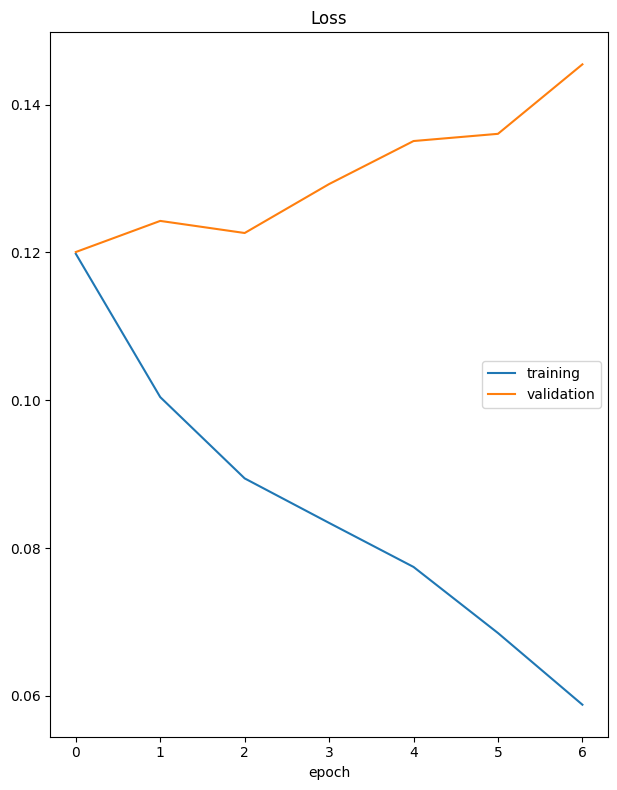

Loss
	training         	 (min:    0.059, max:    0.120, cur:    0.059)
	validation       	 (min:    0.120, max:    0.145, cur:    0.145)
1265/1265 ━━━━━━━━━━━━━━━━━━━━ 481s 380ms/step - loss: 0.0606 - val_loss: 0.1454
Epoch 8/15
 776/1265 ━━━━━━━━━━━━━━━━━━━━ 2:51 351ms/step - loss: 0.0518

[W 2024-07-28 11:53:27,797] Trial 0 failed with parameters: {'TIME_SERIES_SIZE': 41, 'n_layers': 5, 'activation': 'tanh', 'n_units_l0': 432, 'n_units_l1': 323, 'n_units_l2': 438, 'n_units_l3': 160, 'n_units_l4': 92, 'learning_rate': 0.007145866149604852} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "d:\OneDrive\Documents\Uni\Machine Learning in Mechanics\GoogleDecimeterChallenge\.venv\Lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\Torbe\AppData\Local\Temp\ipykernel_11444\2647981383.py", line 26, in objective
    history = model.fit(train_input_data_padded_normalized, train_gt_data_padded_normalized, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.1, callbacks=[PlotLossesKeras(), DecimeterError()], verbose=1)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

KeyboardInterrupt: 

In [8]:
study = optuna.create_study(direction="minimize", study_name="GNSS_LSTM")
study.optimize(objective, n_trials=20)

In [3]:
save_path = "optuna_results"
study_name = "LSTM for GNSS"
os.makedirs(save_path, exist_ok=True)
save_study = optuna.create_study(study_name=study_name, storage=f"sqlite:///{save_path}/{study_name}.db")
save_study.add_trials(study.trials)
study.trials_dataframe().to_csv(f"{save_path}/{study_name}.csv")
print(study.best_params)

DuplicatedStudyError: Another study with name 'LSTM for GNSS' already exists. Please specify a different name, or reuse the existing one by setting `load_if_exists` (for Python API) or `--skip-if-exists` flag (for CLI).

In [5]:
loaded_study = optuna.load_study(study_name=study_name, storage=f"sqlite:///{save_path}/{study_name}.db")
print(loaded_study.best_params)

{'TIME_SERIES_SIZE': 11, 'n_layers': 3, 'activation': 'relu', 'n_units_l0': 95, 'n_units_l1': 18, 'n_units_l2': 100, 'learning_rate': 1.8400133435737296e-05}


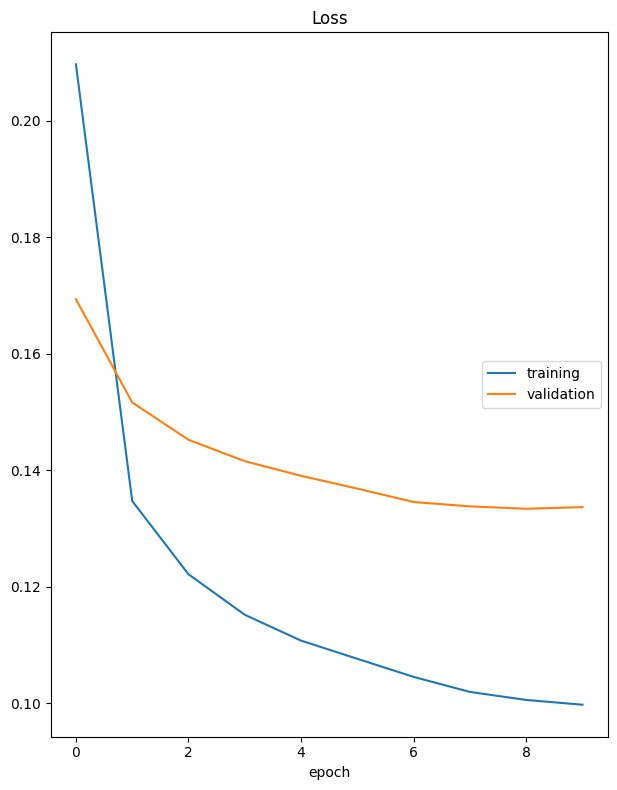

Loss
	training         	 (min:    0.100, max:    0.210, cur:    0.100)
	validation       	 (min:    0.133, max:    0.169, cur:    0.134)


KeyboardInterrupt: 

In [13]:
#train model with best params
SAMPLES = 20
params = loaded_study.best_params

global train_input_data_padded_normalized, train_gt_data_padded_normalized, gt_scaler
TIME_SERIES_SIZE = params["TIME_SERIES_SIZE"]
train_input_data, train_gt_data = read_data(SAMPLES)
train_input_data_padded, train_gt_data_padded = sort_data(TIME_SERIES_SIZE, train_input_data, train_gt_data, MAX_TRAJECTORIES=SAMPLES)
train_input_data_padded_normalized, train_gt_data_padded_normalized, scaler, gt_scaler = normalize_data(train_input_data_padded, train_gt_data_padded)

n_layers = params["n_layers"]
activation = params["activation"]
model = Sequential()
model.add(Masking(mask_value=0, input_shape=(train_input_data_padded_normalized.shape[1], train_input_data_padded_normalized.shape[2])))
for i in range(n_layers):
    model.add(LSTM(params[f"n_units_l{i}"] , activation=activation, return_sequences=True))
model.add(Dense(7, activation="linear"))

learning_rate = params["learning_rate"]

model.compile(optimizer=Adam(learning_rate), loss="MeanSquaredError")

history = model.fit(train_input_data_padded_normalized, train_gt_data_padded_normalized, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[PlotLossesKeras(), DecimeterError()], validation_split=0.2, verbose=1)
#return validation score as indicator for the model quality
print(history.history["val_loss"][-1])


In [84]:
def sort_data_for_usage(TIME_SERIES_SIZE, train_input_data, train_gt_data, number_of_features,MAX_TRAJECTORIES):
    #move all features with the same timestamp to one line 
    for sample in range(len(train_input_data)):
        matches = 0
        print(f"sample {sample+1} sorted")
        timesteps = 0
        for step in range(len(train_input_data[sample])):
            if step != 0:
                if train_input_data[sample][step-matches][0] == train_input_data[sample][step-1-matches][0]:
                    train_input_data[sample][step-1-matches].extend(train_input_data[sample][step-matches][1:])
                    train_input_data[sample].pop(step-matches)
                    matches +=1
                else:
                    timesteps+=1


    #read in imu data and add it to the train data
    print("reading imu data")
    IMU_data = read_imu_data(train_input_data, MAX_TRAJECTORIES)
    

    

    #prepare batches of time series of size TIME_SERIES_SIZE
    print("batching data")
    train_input_data_batched = [sample[i:i+TIME_SERIES_SIZE] for sample in train_input_data for i in range(0,len(sample)-TIME_SERIES_SIZE)]
    train_gt_data_batched  = []
    for sample in train_gt_data:
        train_gt_data_batched.extend([sample[i:i+TIME_SERIES_SIZE] for i in range(0,len(sample)-TIME_SERIES_SIZE)])
    train_gt_data_batched = np.array(train_gt_data_batched)
    #train_input_data_batched = np.array(train_input_data_batched)
    IMU_data_batched = [sample[i:i+TIME_SERIES_SIZE] for sample in IMU_data for i in range(0,len(sample)-TIME_SERIES_SIZE)]
    IMU_data_batched = np.array(IMU_data_batched)


    #pad input data
    print("padding train data")


    train_input_data_padded = [tf.keras.preprocessing.sequence.pad_sequences(sample,value=0, padding="post", dtype=np.float64, maxlen=number_of_features) for sample in train_input_data_batched]
    train_input_data_padded = np.array(train_input_data_padded)

    del train_input_data, train_input_data_batched
    
    print(train_input_data_padded.shape)
    print(IMU_data_batched.shape)
    #insert IMU data at the end of train data
    print("inserting IMU data")
    train_input_data_padded = np.concatenate((train_input_data_padded, IMU_data_batched), axis=2)
    del IMU_data_batched
    print(train_input_data_padded.shape)

    #pad ground truth data
    print("padding gt data")
    #max_features_gt = max(len(feature) for sample in train_gt_data_batched for feature in sample)
    train_gt_data_padded = np.array(train_gt_data_batched)

    #convert to right data format
    # train_gt_data_padded = [tf.keras.preprocessing.sequence.pad_sequences(sample, value=0,padding="post", dtype=np.float64, maxlen=max_features_gt) for sample in train_gt_data_batched]
    # train_gt_data_padded = np.array(train_gt_data_padded)
    del train_gt_data, train_gt_data_batched

    print(train_input_data_padded.shape)
    print(train_gt_data_padded.shape)

    if(train_input_data_padded.shape[0] > train_gt_data_padded.shape[0]):
        train_input_data_padded = train_input_data_padded[:train_gt_data_padded.shape[0]]
    elif(train_input_data_padded.shape[0] < train_gt_data_padded.shape[0]):
        train_gt_data_padded = train_gt_data_padded[:train_input_data_padded.shape[0]]

    print(train_input_data_padded.shape)
    print(train_gt_data_padded.shape)
    


    return train_input_data_padded, train_gt_data_padded


In [90]:
# visulaize trajectory on map
path_data = read_data(1)
path_input_data, path_gt_data = sort_data_for_usage(TIME_SERIES_SIZE, path_data[0], path_data[1],model.input_shape[2]-18, 1)
path_input_data_normalized, path_gt_data_normalized, scaler, gt_scaler = normalize_data(path_input_data, path_gt_data)

print(model.summary())
print(path_input_data_normalized.shape)

prediction = model.predict(path_input_data_normalized)
prediction = np.array([gt_scaler.inverse_transform(sample) for sample in prediction])
gt = np.array([gt_scaler.inverse_transform(sample) for sample in path_gt_data_normalized])


predicted_path = prediction[:,-1,0:3]
gt_path = path_gt_data[:,-1,0:3]
print(predicted_path.shape)
print(gt_path.shape)
#plot it on a map


m = folium.Map(location=[predicted_path[0,0], predicted_path[0,1]], zoom_start=25, max_zoom=35)

for i in range(len(predicted_path)-1):
    folium.PolyLine([[predicted_path[i,0], predicted_path[i,1]], [predicted_path[i+1,0], predicted_path[i+1,1]]], color="blue").add_to(m)
    folium.PolyLine([[gt_path[i,0], gt_path[i,1]], [gt_path[i+1,0], gt_path[i+1,1]]], color="red").add_to(m)

folium.Marker([predicted_path[-1,0], predicted_path[-1,1]], popup=f"predicted: {predicted_path[-1,0]}, {predicted_path[-1,1]}", icon=folium.Icon(color="red")).add_to(m)
folium.Marker([gt_path[-1,0], gt_path[-1,1]], popup=f"gt: {gt_path[-1,0]}, {gt_path[-1,1]}", icon=folium.Icon(color="red")).add_to(m)

m.save("map.html")





read in 1 samples
sample 1 sorted
reading imu data
read in 1 samples
batching data
padding train data
(1289, 11, 241)
(1289, 11, 18)
inserting IMU data
(1289, 11, 259)
padding gt data
(1289, 11, 259)
(1288, 11, 7)
(1288, 11, 259)
(1288, 11, 7)
normalizing data


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_1 (Masking)             │ (None, 11, 259)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 11, 95)         │       134,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 11, 18)         │         8,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 11, 100)        │        47,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11, 7)          │           707 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 574,247 (2.19 MB)

 Trainable params: 191,415 (747.71 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 382,832 (1.46 MB)

None
(1288, 11, 259)
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
(1288, 3)
(1288, 3)
